## Forex Stock Market Price Prediction using Deep Neural Networks (Transformers)

In [1]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

import warnings
warnings.filterwarnings('ignore')

physical_devices = tf.config.list_physical_devices()
print('Physical devices: {}'.format(physical_devices))

# Filter out the CPUs and keep only the GPUs
gpus = [device for device in physical_devices if 'GPU' in device.device_type]

# If GPUs are available, set memory growth to True
if len(gpus) > 0:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print('GPU memory growth: True')



Tensorflow version: 2.17.0
Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Hyperparameters

In [2]:
batch_size = 32
seq_len = 128

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

## Load IBM data

In [3]:
IBM_path = 'XAUUSD240.csv'

df = pd.read_csv(IBM_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)
df.tail()

,Date,Open,High,Low,Close,Volume
26690,2024-08-14 16:00,2443.955,2448.275,2438.000,2447.115,240
26691,2024-08-14 20:00,2447.075,2449.348,2446.355,2449.295,180
26692,2024-08-15 00:00,2449.315,2454.195,2448.075,2453.565,240
26693,2024-08-15 04:00,2453.565,2458.665,2450.205,2455.665,240
26694,2024-08-15 08:00,2455.665,2457.095,2453.485,2455.358,60


In [4]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2007-12-20 20:00,795.265,797.247,795.112,796.714,149
1,2007-12-21 00:00,796.455,799.093,796.455,797.663,227
2,2007-12-21 04:00,797.606,801.902,797.205,800.938,239
3,2007-12-21 08:00,801.059,803.933,799.372,803.860,240
4,2007-12-21 12:00,803.854,812.055,802.389,808.873,240


In [13]:
# print the shape of the dataset
print('Shape of the dataframe: {}'.format(df.shape))

Shape of the dataframe: (26695, 6)


## Plot daily XAUUSD closing prices and volume

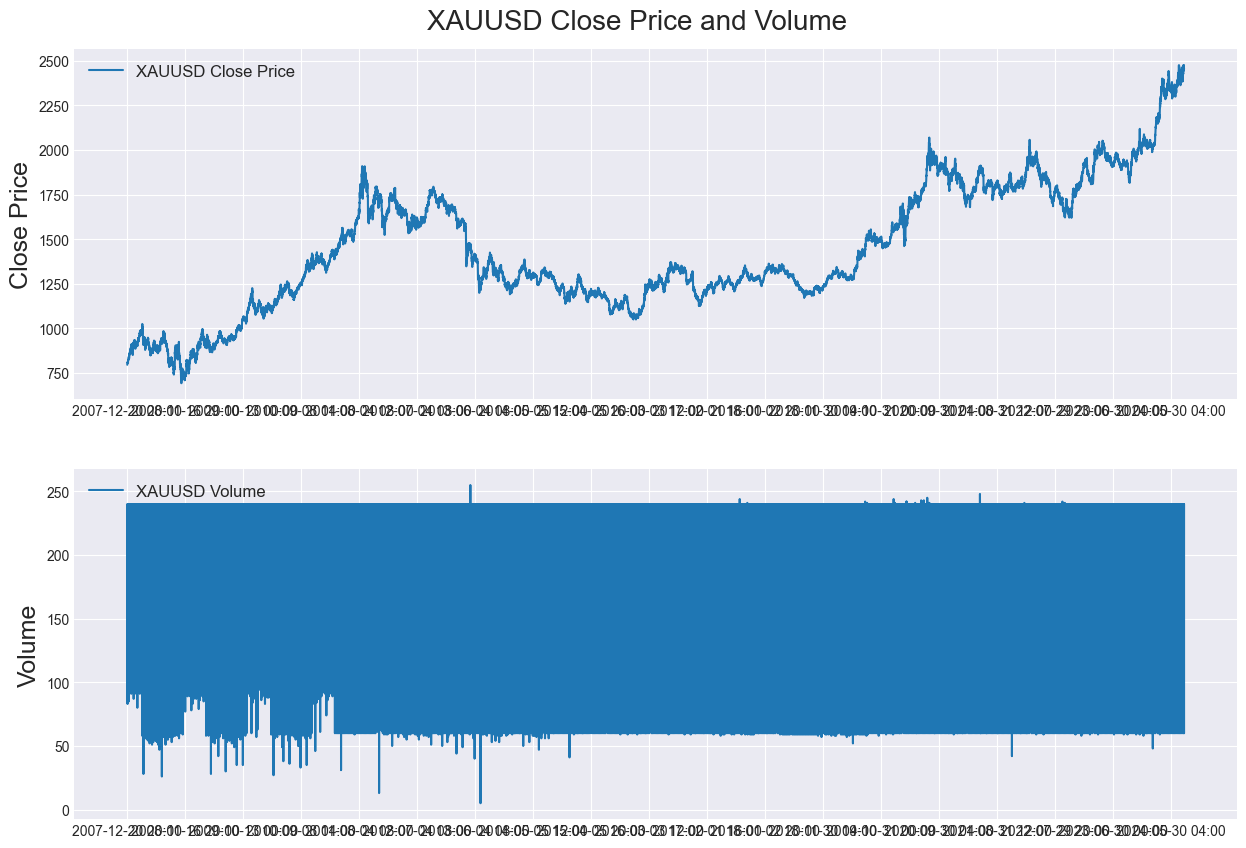

In [4]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("XAUUSD Close Price and Volume", fontsize=20)
st.set_y(0.92)



ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='XAUUSD Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='XAUUSD Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['Date'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

## Calculate normalized percentage change of all columns

In [5]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

###############################################################################
'''Normalize price columns'''
#
min_return = min(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (21356, 5)
Validation data shape: (2669, 5)
Test data shape: (2669, 5)


,Open,High,Low,Close,Volume
1,0.516002,0.521791,0.517364,0.513845,0.030264
2,0.515641,0.530270,0.512082,0.534443,0.020444
3,0.536023,0.523327,0.524638,0.531210,0.019429
4,0.530086,0.576826,0.532100,0.549499,0.019341
5,0.548330,0.504313,0.559136,0.517528,0.018733


## Plot 4H changes of close prices and volume

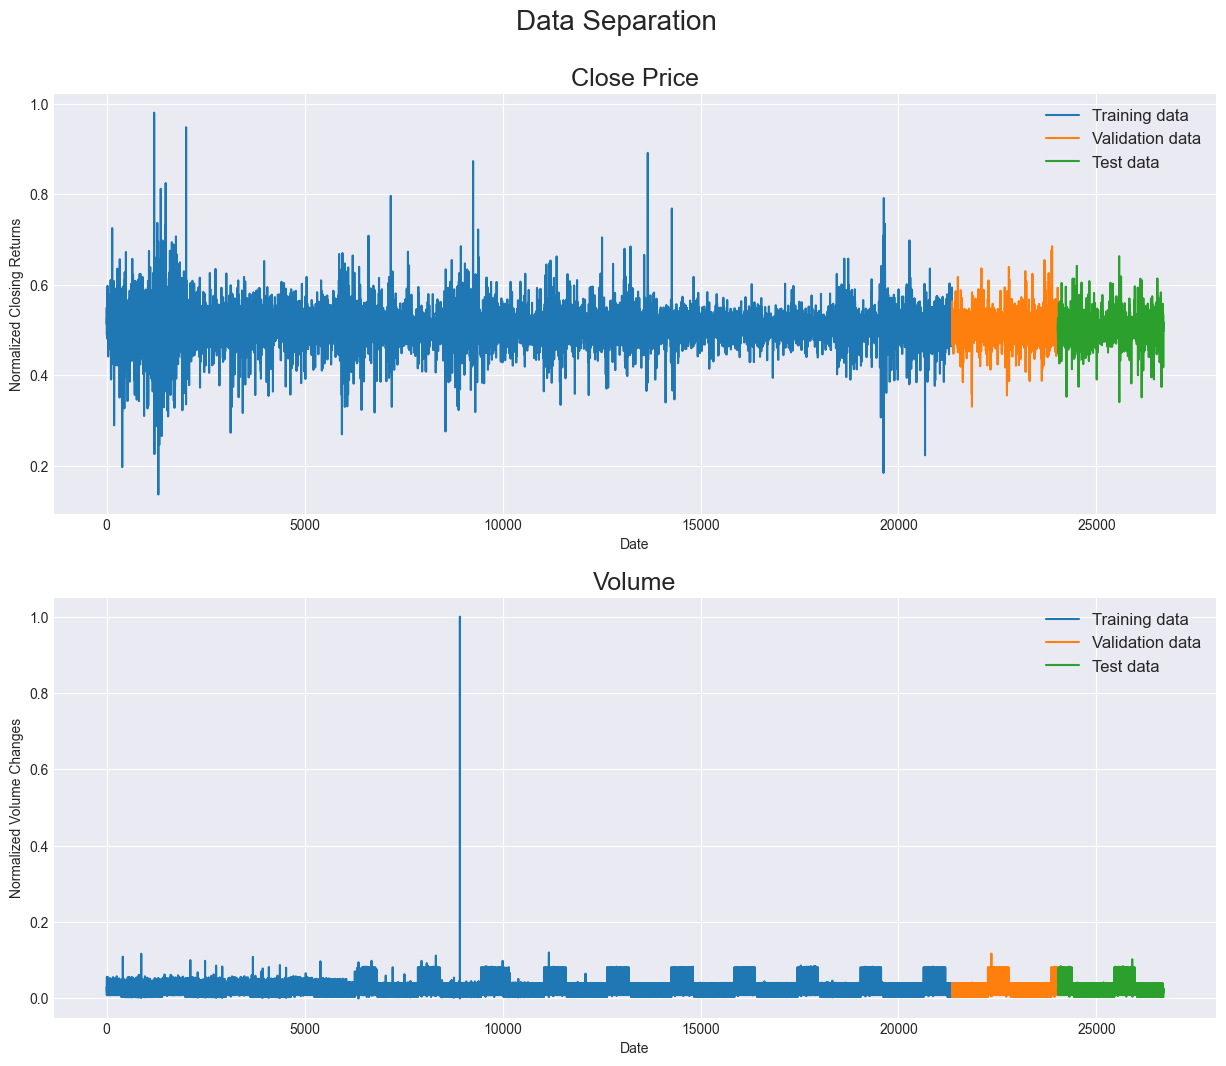

In [6]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

## Create chunks of training, validation and test data

In [7]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (21228, 128, 5) (21228,)
Validation set shape (2541, 128, 5) (2541,)
Testing set shape (2541, 128, 5) (2541,)


## TimeVector

In [8]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config
  

## Transformer

In [9]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config          

## Model

664/664 ━━━━━━━━━━━━━━━━━━━━ 79s 117ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step
 
Evaluation metrics
Training Data - Loss: 0.0010, MAE: 0.0194, MAPE: 3.9355
Validation Data - Loss: 0.0006, MAE: 0.0168, MAPE: 3.3444
Test Data - Loss: 0.0006, MAE: 0.0157, MAPE: 3.1209


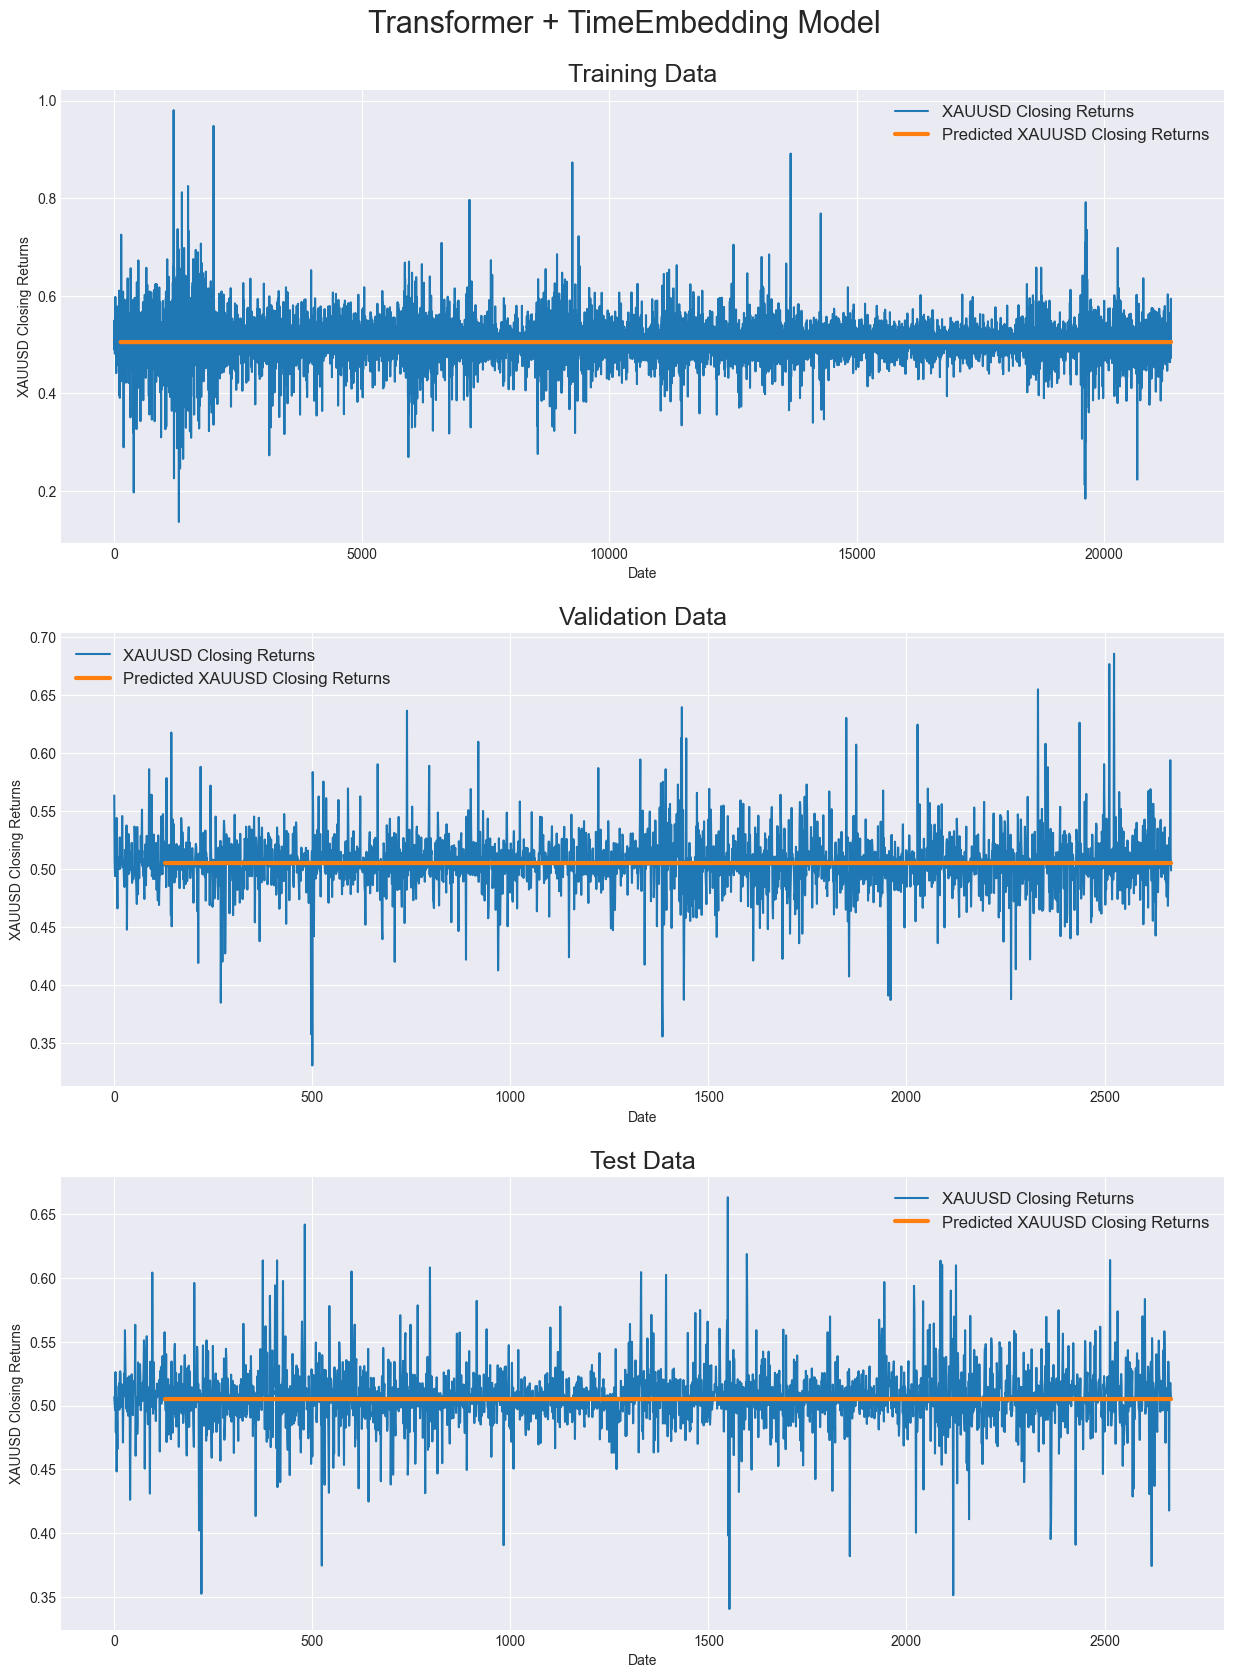

In [12]:
# def create_model():
#   '''Initialize time and transformer layers'''
#   time_embedding = Time2Vector(seq_len)
#   attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
#   attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
#   attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

#   '''Construct model'''
#   in_seq = Input(shape=(seq_len, 5))
#   x = time_embedding(in_seq)
#   x = Concatenate(axis=-1)([in_seq, x])
#   x = attn_layer1((x, x, x))
#   x = attn_layer2((x, x, x))
#   x = attn_layer3((x, x, x))
#   x = GlobalAveragePooling1D(data_format='channels_first')(x)
#   x = Dropout(0.1)(x)
#   x = Dense(64, activation='relu')(x)
#   x = Dropout(0.1)(x)
#   out = Dense(1, activation='linear')(x)

#   model = Model(inputs=in_seq, outputs=out)
#   model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
#   return model


# model = create_model()
# model.summary()

# callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.keras', 
#                                               monitor='val_loss', 
#                                               save_best_only=True, verbose=1)

# history = model.fit(X_train, y_train, 
#                     batch_size=batch_size, 
#                     epochs=35, 
#                     callbacks=[callback],
#                     validation_data=(X_val, y_val))  

model = tf.keras.models.load_model('Transformer+TimeEmbedding.keras',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='XAUUSD Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted XAUUSD Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('XAUUSD Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='XAUUSD Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted XAUUSD Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('XAUUSD Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='XAUUSD Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted XAUUSD Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('XAUUSD Closing Returns')
ax31.legend(loc="best", fontsize=12)

664/664 ━━━━━━━━━━━━━━━━━━━━ 72s 107ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step
 
Evaluation metrics
Training Data - Loss: 0.2568, MAE: 0.5057, MAPE: 100.0000
Validation Data - Loss: 0.2561, MAE: 0.5054, MAPE: 100.0000
Test Data - Loss: 0.2568, MAE: 0.5062, MAPE: 100.0000


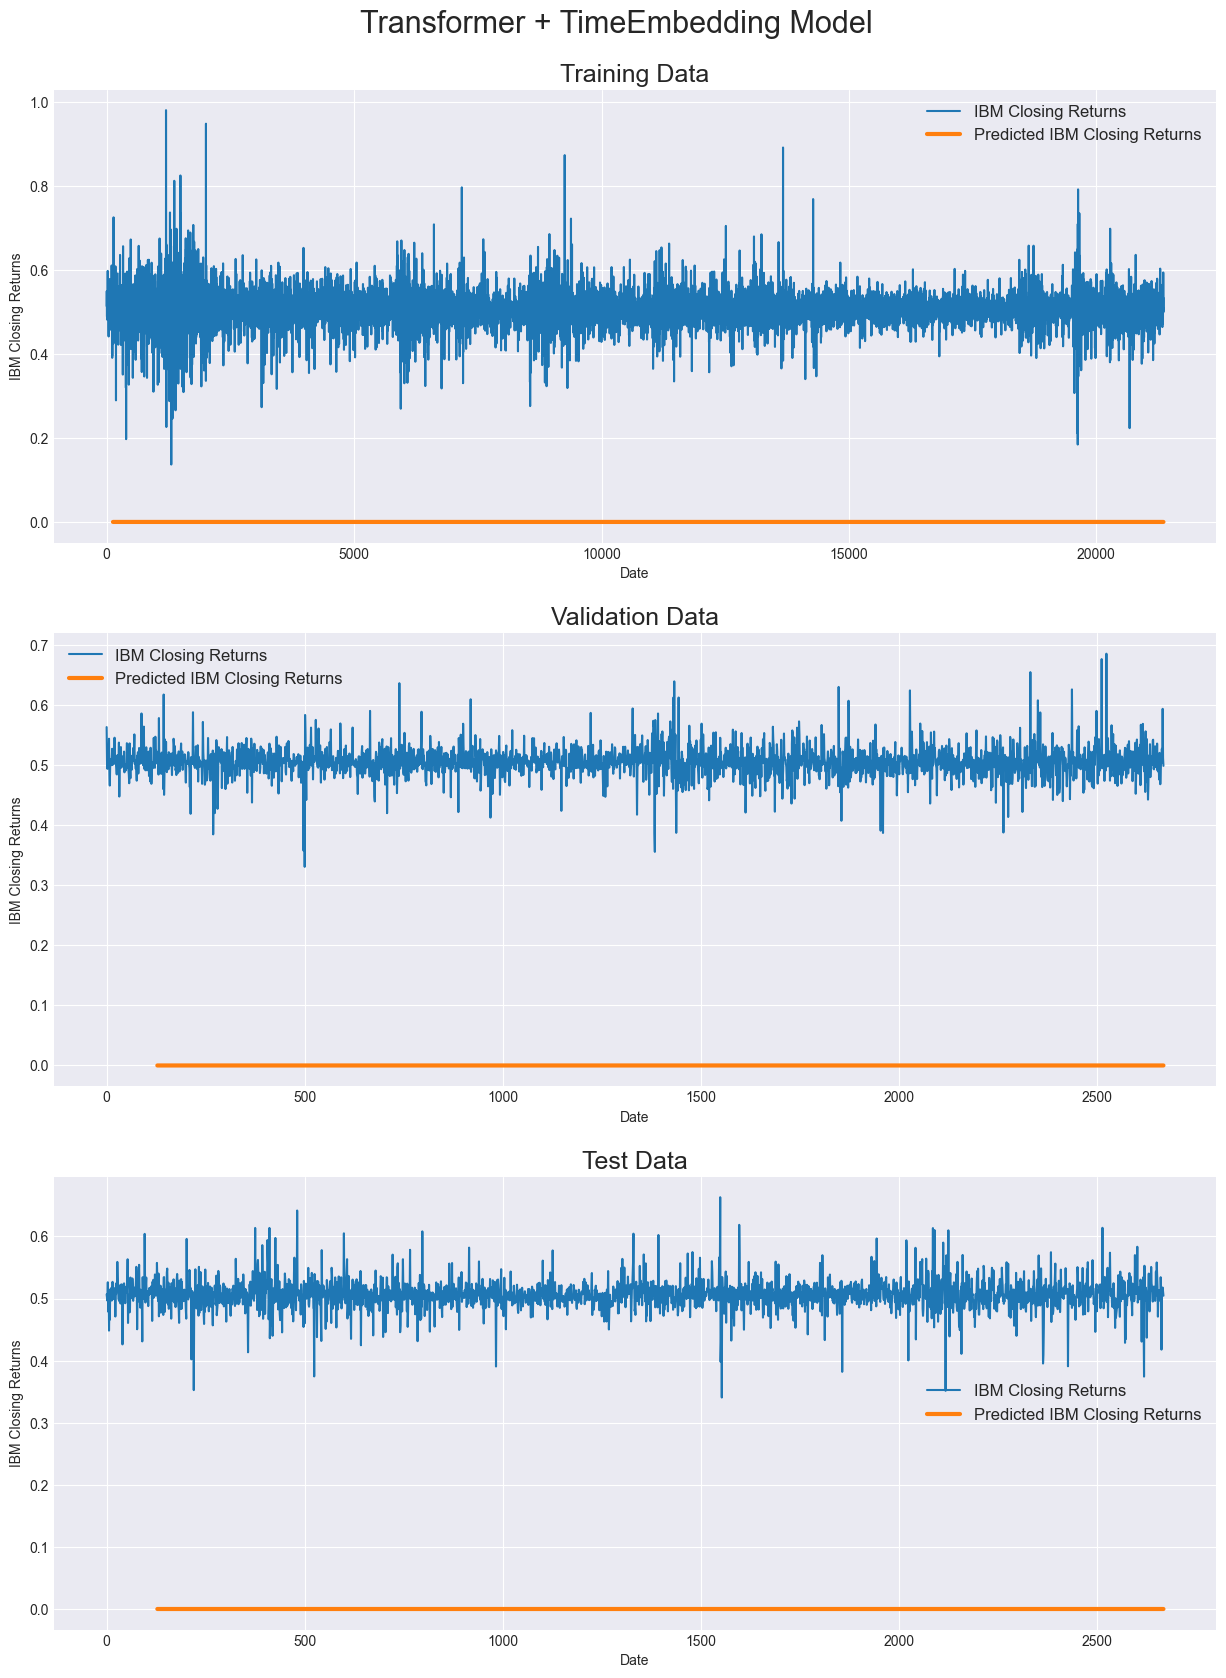

In [21]:
###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='XAUUSD Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted XAUUSD Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('XAUUSD Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='XAUUSD Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted XAUUSD Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('XAUUSD Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='XAUUSD Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted XAUUSD Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('XAUUSD Closing Returns')
ax31.legend(loc="best", fontsize=12)

## Model metrics

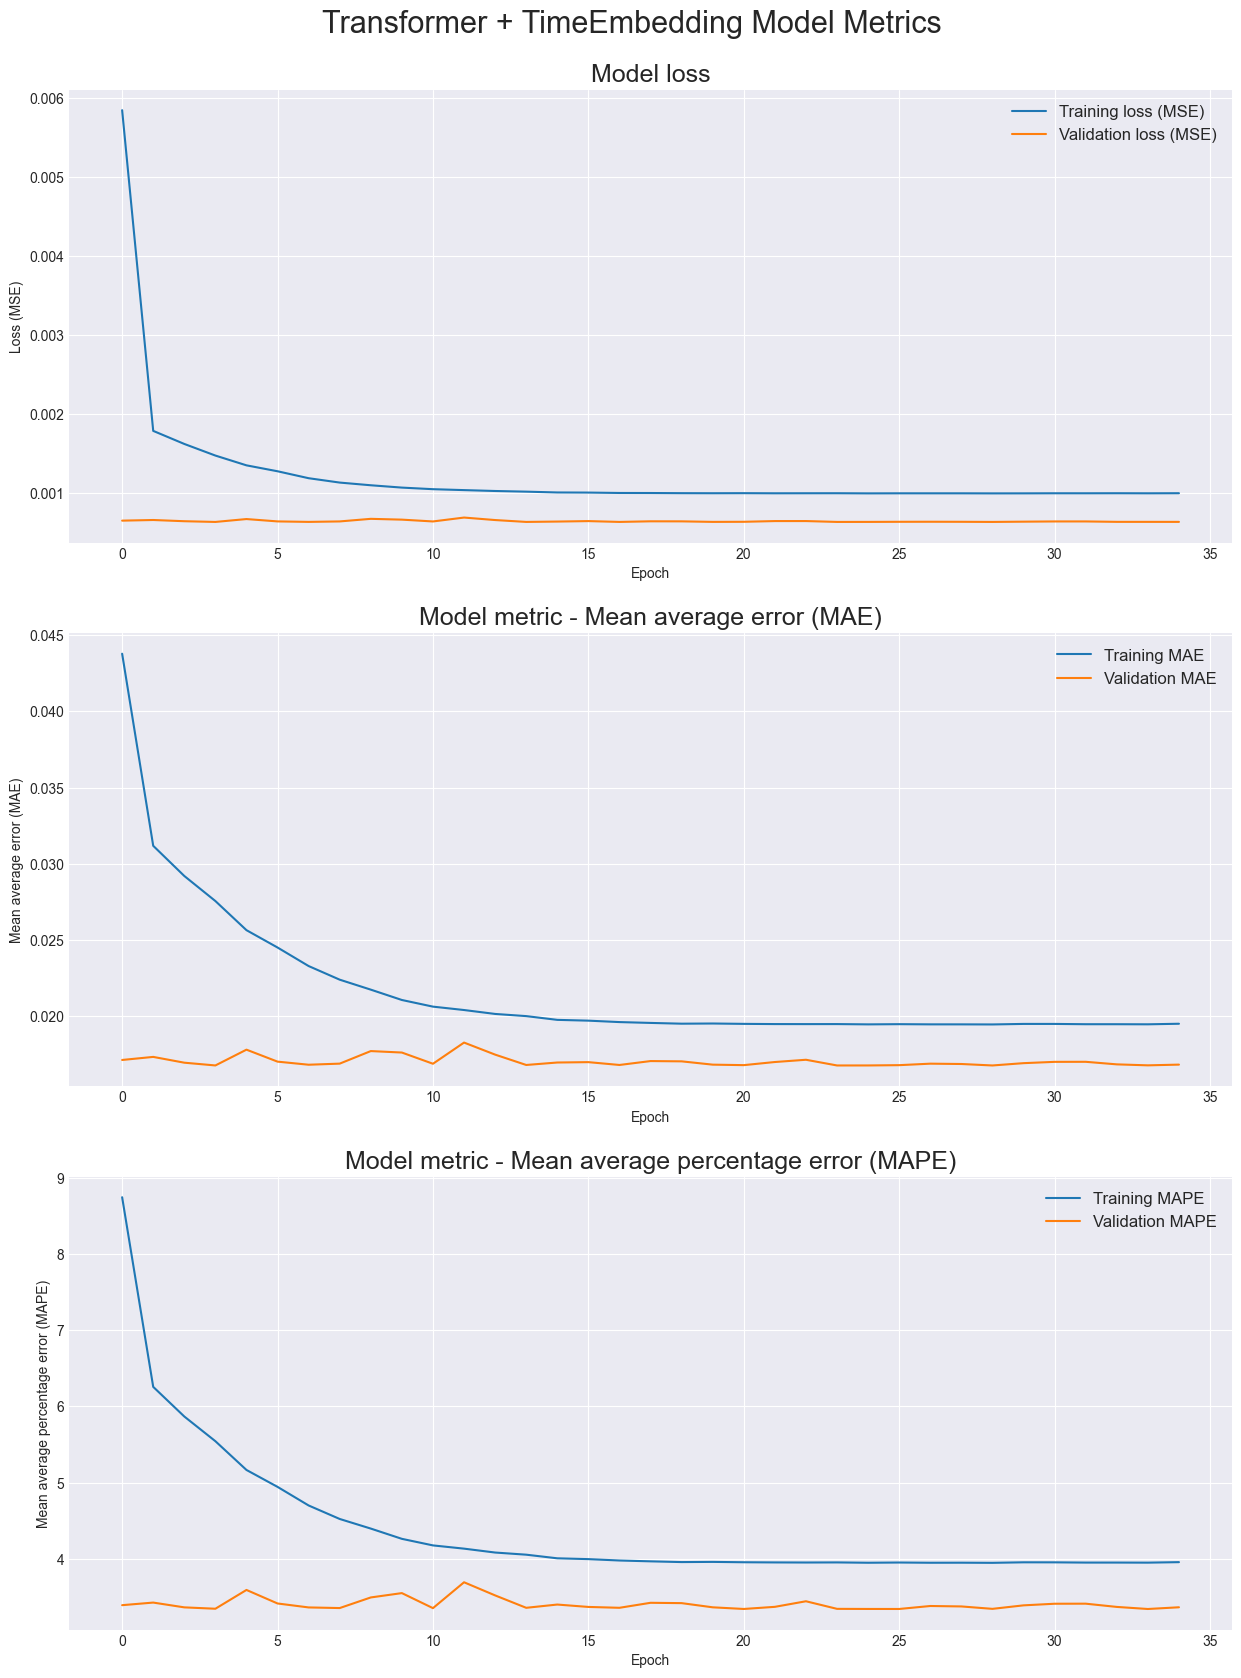

In [23]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

## Model architecture overview

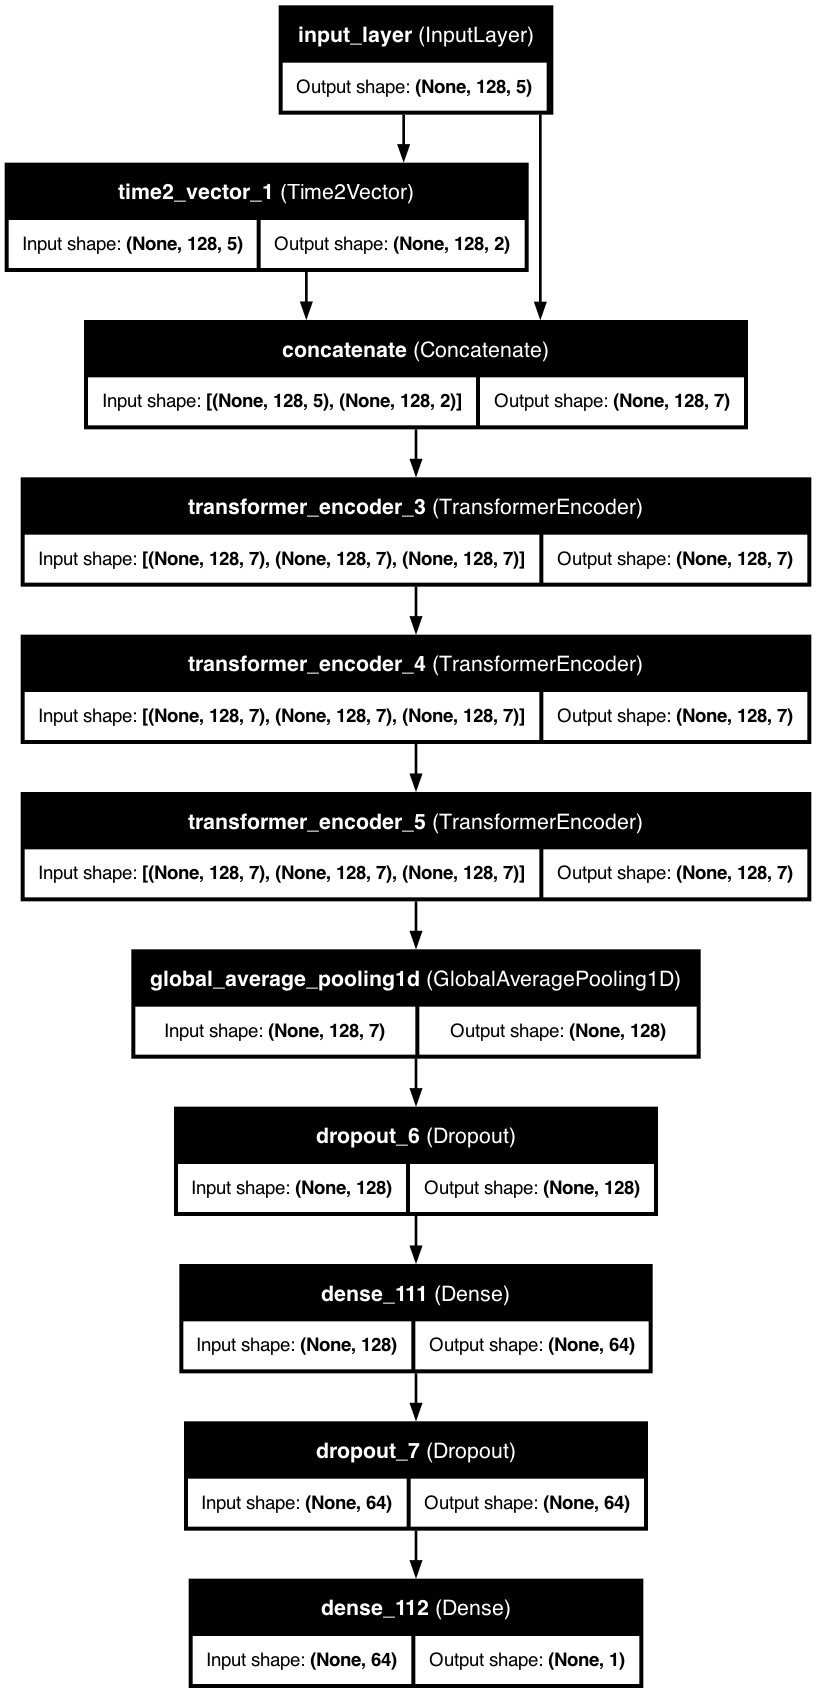

In [28]:
tf.keras.utils.plot_model(
    model,
    to_file="IBM_Transformer+TimeEmbedding.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,)

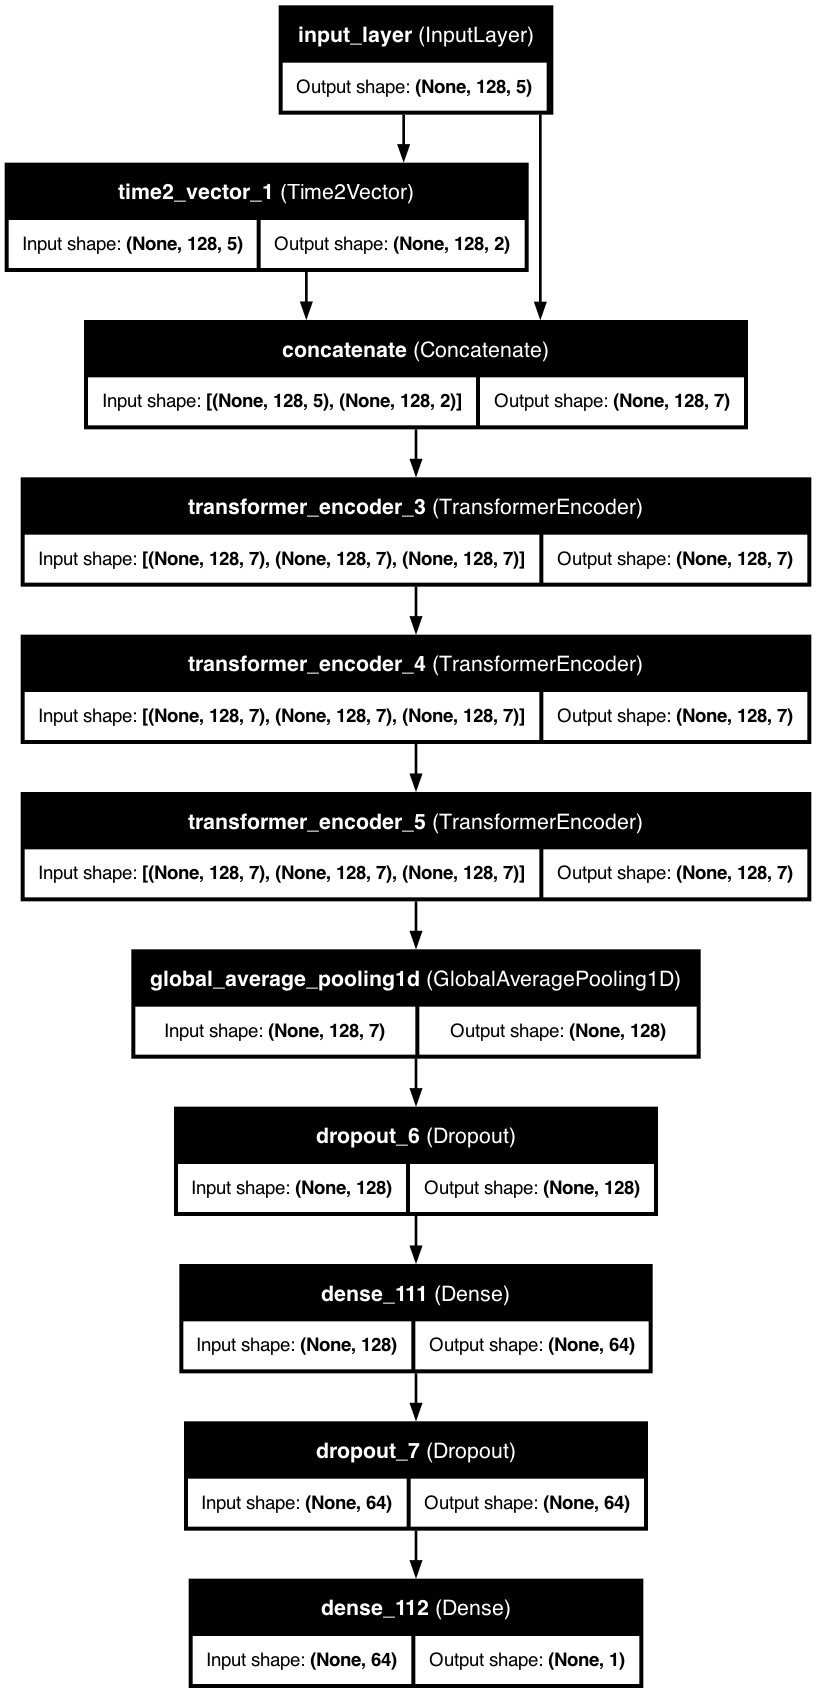

In [29]:
tf.keras.utils.plot_model(
    model,
    to_file="IBM_Transformer+TimeEmbedding.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,)

# Moving Average

## Moving Average - Load IBM data again, to apply rolling window

In [4]:
IBM_path = 'XAUUSD240.csv'

df = pd.read_csv(IBM_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)

# Apply moving average with a window of 10 days to all columns
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(10).mean() 

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 
df.head()

,Date,Open,High,Low,Close,Volume
9,2007-12-24 04:00,804.1986,806.9554,803.4204,805.7790,197.8
10,2007-12-24 08:00,805.6277,808.5011,804.8007,807.3198,206.9
11,2007-12-24 12:00,807.1926,810.0989,806.0679,808.7300,208.2
12,2007-12-24 16:00,808.5932,811.2165,807.4527,809.8727,204.9
13,2007-12-24 20:00,809.7262,812.0621,808.6224,810.6465,193.4


## Moving Average - Plot daily IBM closing prices and volume

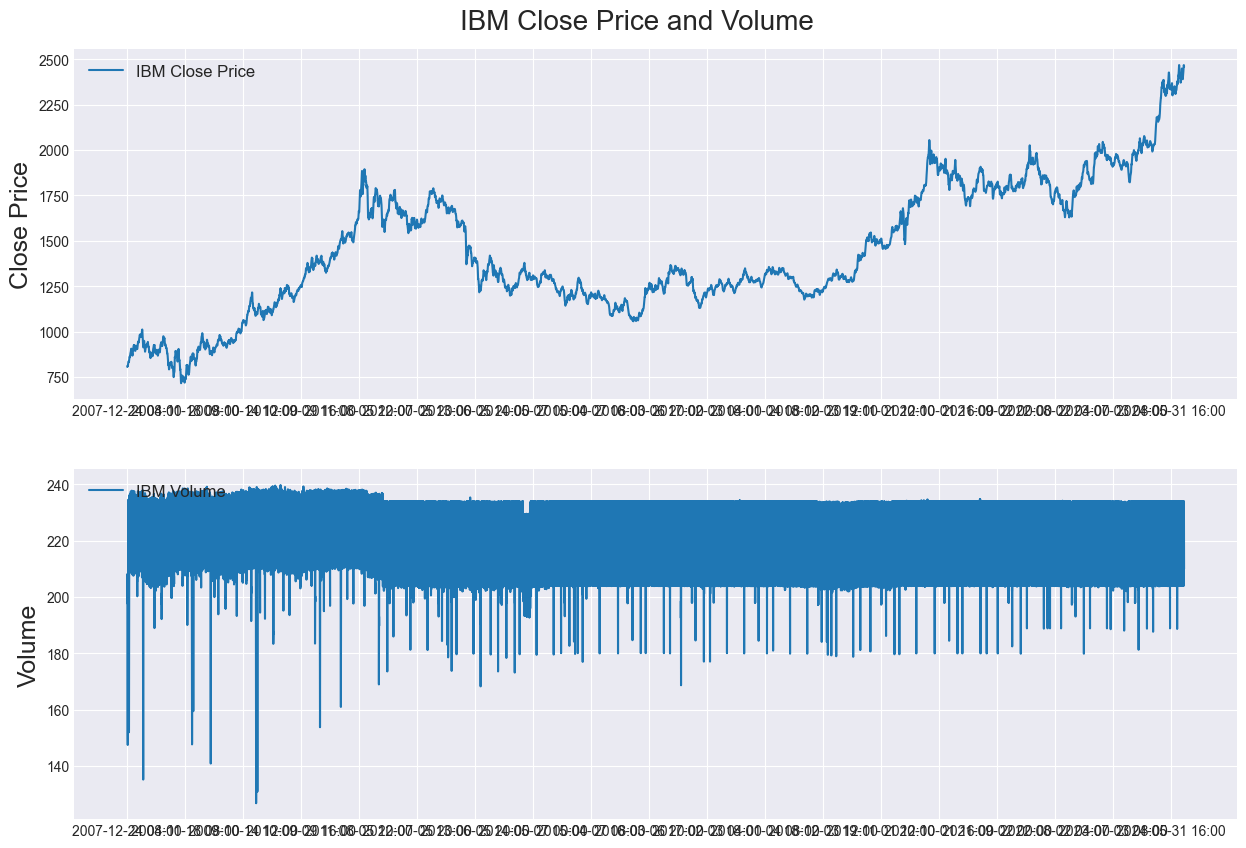

In [5]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("IBM Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='IBM Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='IBM Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['Date'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

## Moving Average - Calculate normalized percentage change for all columns

In [6]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

###############################################################################
'''Normalize price columns'''
#
min_return = min(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (21348, 5)
Validation data shape: (2669, 5)
Test data shape: (2668, 5)


,Open,High,Low,Close,Volume
10,0.548798,0.553480,0.546802,0.553368,0.684612
11,0.554392,0.555535,0.541949,0.547774,0.528274
12,0.547381,0.535355,0.546800,0.536484,0.441163
13,0.536086,0.523951,0.537691,0.521011,0.282653
14,0.522462,0.488488,0.515323,0.488484,0.269518


## Moving Average - Plot daily changes of close price and volume

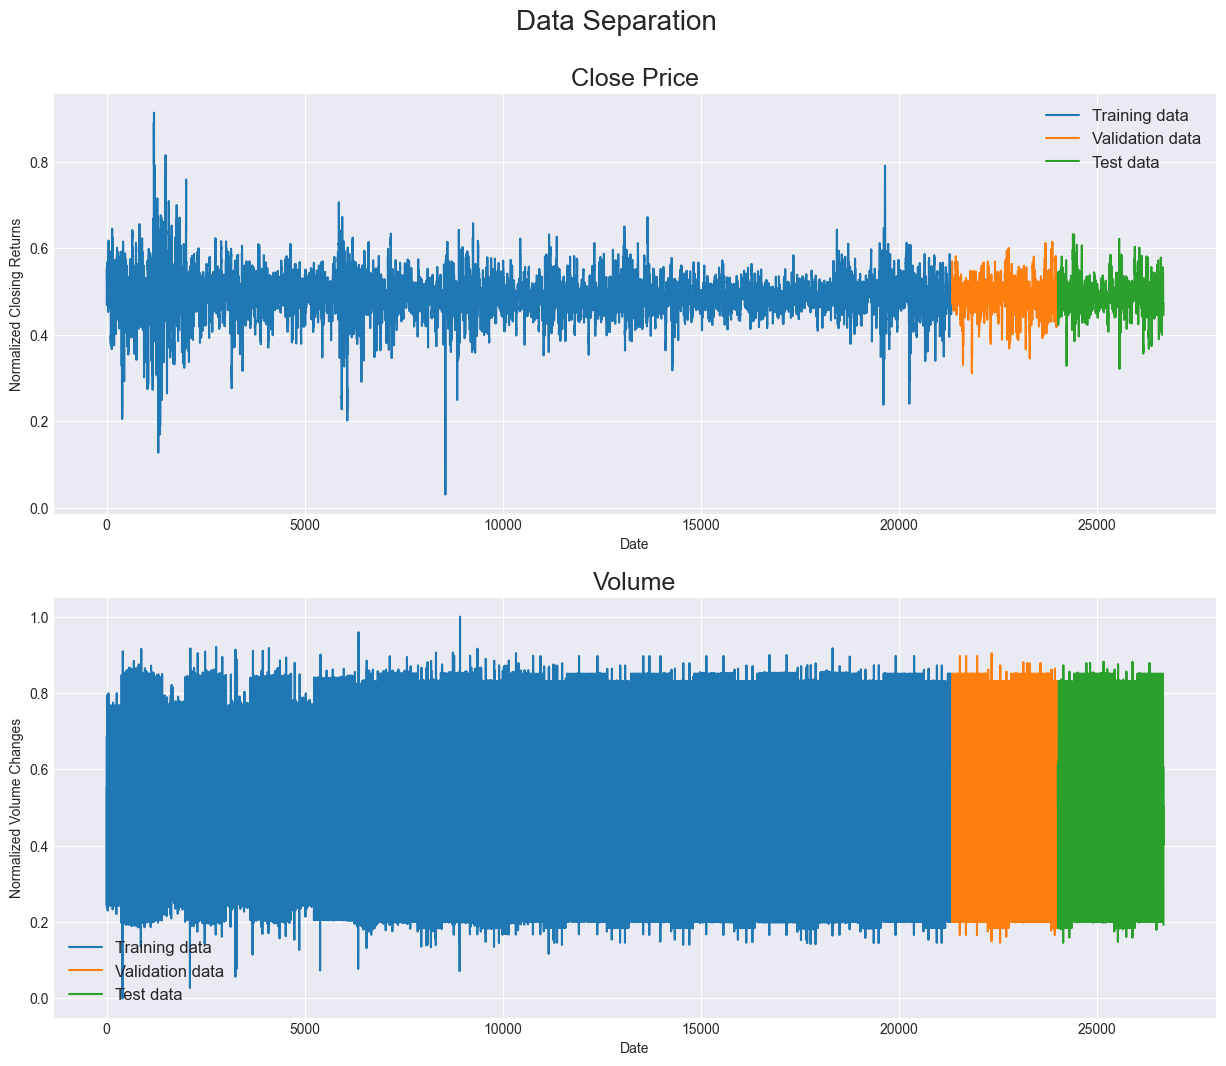

In [40]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

## Moving Average - Create chunks of training, validation, and test data

In [9]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(21220, 128, 5) (21220,)
(2541, 128, 5) (2541,)


## Moving Average - Model

In [13]:
# def create_model():
#   '''Initialize time and transformer layers'''
#   time_embedding = Time2Vector(seq_len)
#   attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
#   attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
#   attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

#   '''Construct model'''
#   in_seq = Input(shape=(seq_len, 5))
#   x = time_embedding(in_seq)
#   x = Concatenate(axis=-1)([in_seq, x])
#   x = attn_layer1((x, x, x))
#   x = attn_layer2((x, x, x))
#   x = attn_layer3((x, x, x))
#   x = GlobalAveragePooling1D(data_format='channels_first')(x)
#   x = Dropout(0.1)(x)
#   x = Dense(64, activation='relu')(x)
#   x = Dropout(0.1)(x)
#   out = Dense(1, activation='linear')(x)

#   model = Model(inputs=in_seq, outputs=out)
#   model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
#   return model


# model = create_model()
# model.summary()

# callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding2.keras', 
#                                               monitor='val_loss', 
#                                               save_best_only=True, 
#                                               verbose=1)

# history = model.fit(X_train, y_train, 
#                     batch_size=batch_size, 
#                     epochs=35, 
#                     callbacks=[callback],
#                     validation_data=(X_val, y_val))  

model = tf.keras.models.load_model('Transformer+TimeEmbedding2.keras',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


664/664 ━━━━━━━━━━━━━━━━━━━━ 77s 115ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step
 
Evaluation metrics
Training Data - Loss: 0.0021, MAE: 0.0328, MAPE: 6.4779
Validation Data - Loss: 0.0015, MAE: 0.0295, MAPE: 5.7900
Test Data - Loss: 0.0014, MAE: 0.0278, MAPE: 5.4689


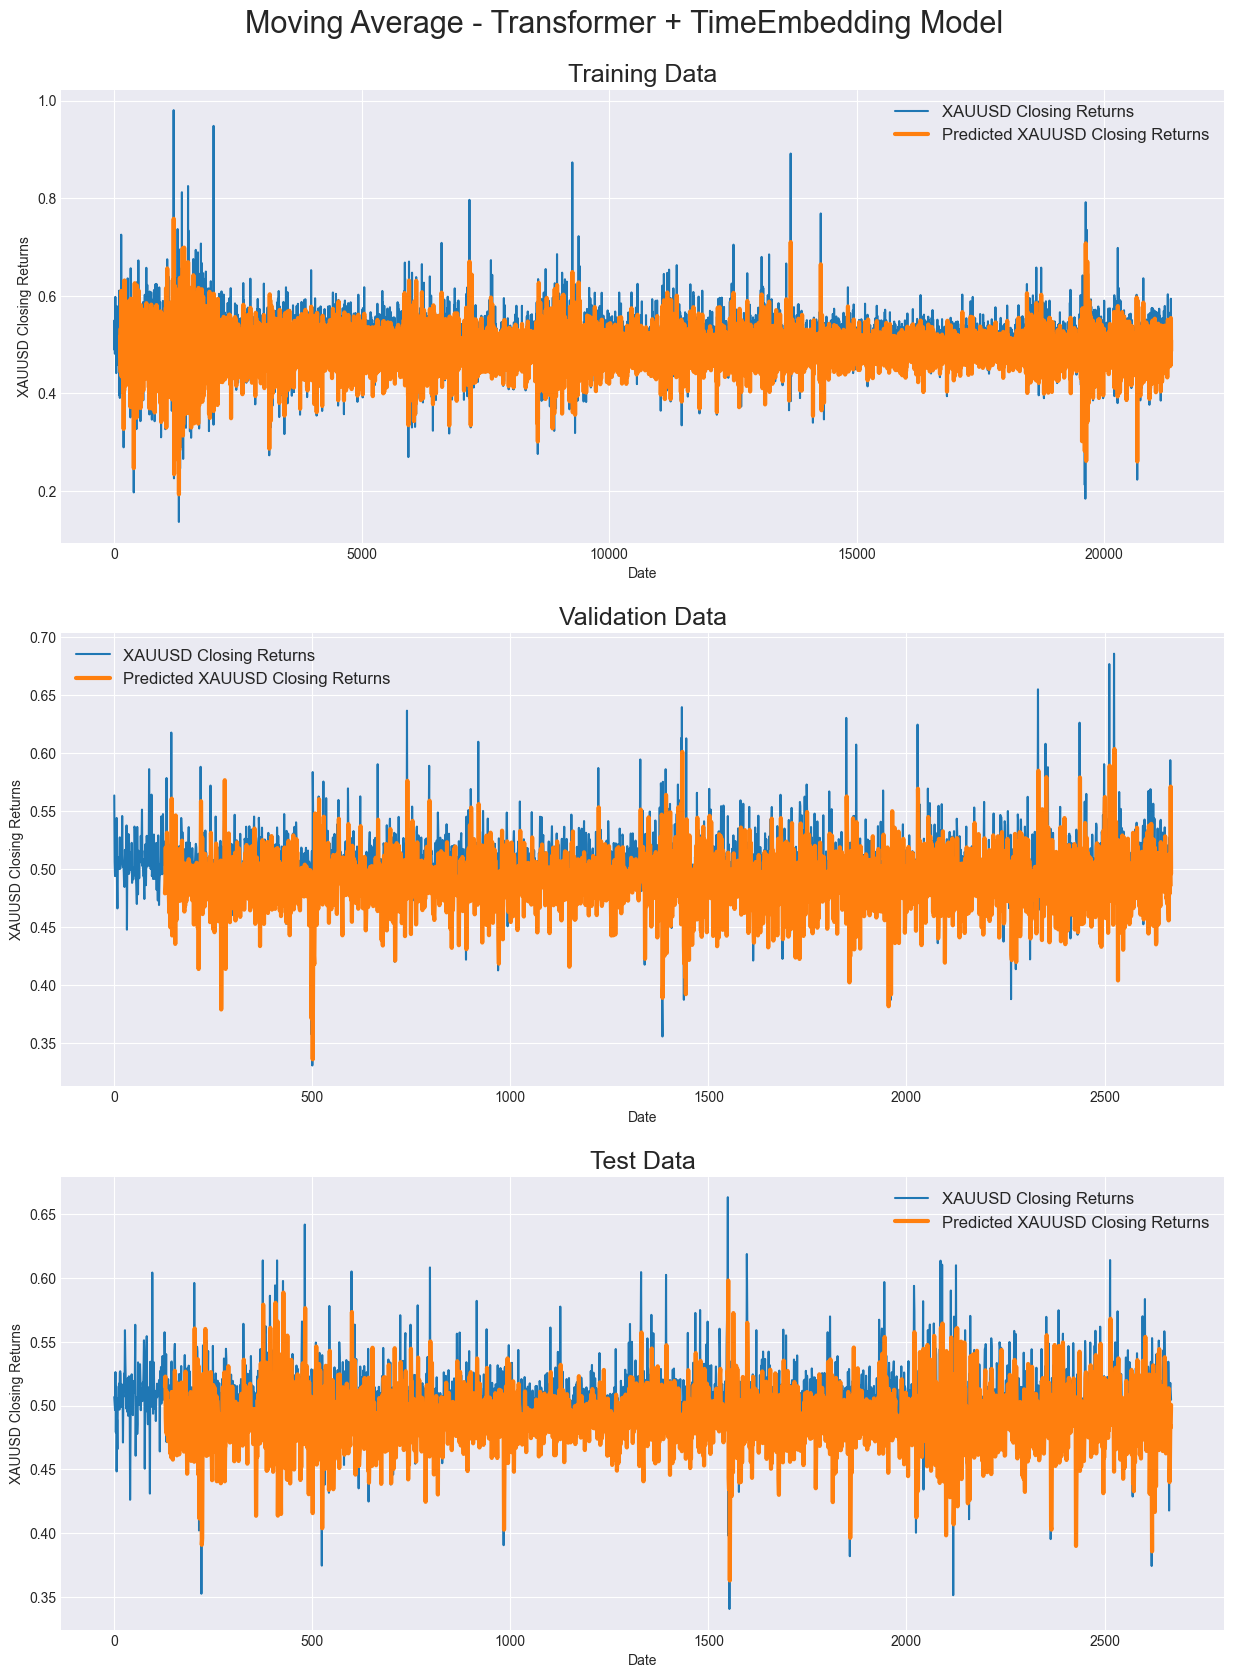

In [15]:
model = tf.keras.models.load_model('Transformer+TimeEmbedding2.keras',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

###############################################################################
'''Calculate predictions and metrics'''

# Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

# Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''De-normalize the predictions'''

# Retrieve the min and max values for the prices and volume (these were used during normalization)
min_return = min(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].max(axis=0))
min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# Function to de-normalize predictions
def denormalize_predictions(pred, min_value, max_value):
    return (pred * (max_value - min_value)) + min_value

# De-normalize predictions for prices
train_pred_denorm = denormalize_predictions(train_pred, min_return, max_return)
val_pred_denorm = denormalize_predictions(val_pred, min_return, max_return)
test_pred_denorm = denormalize_predictions(test_pred, min_return, max_return)

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

# Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='XAUUSD Closing Returns')
ax11.plot(np.arange(seq_len, train_pred_denorm.shape[0]+seq_len), train_pred_denorm, linewidth=3, label='Predicted XAUUSD Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('XAUUSD Closing Returns')
ax11.legend(loc="best", fontsize=12)

# Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='XAUUSD Closing Returns')
ax21.plot(np.arange(seq_len, val_pred_denorm.shape[0]+seq_len), val_pred_denorm, linewidth=3, label='Predicted XAUUSD Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('XAUUSD Closing Returns')
ax21.legend(loc="best", fontsize=12)

# Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='XAUUSD Closing Returns')
ax31.plot(np.arange(seq_len, test_pred_denorm.shape[0]+seq_len), test_pred_denorm, linewidth=3, label='Predicted XAUUSD Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('XAUUSD Closing Returns')
ax31.legend(loc="best", fontsize=12)


664/664 ━━━━━━━━━━━━━━━━━━━━ 67s 100ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step
 
Evaluation metrics
Training Data - Loss: 0.0003, MAE: 0.0113, MAPE: 2.3820
Validation Data - Loss: 0.0002, MAE: 0.0102, MAPE: 2.1127
Test Data - Loss: 0.0002, MAE: 0.0097, MAPE: 1.9786


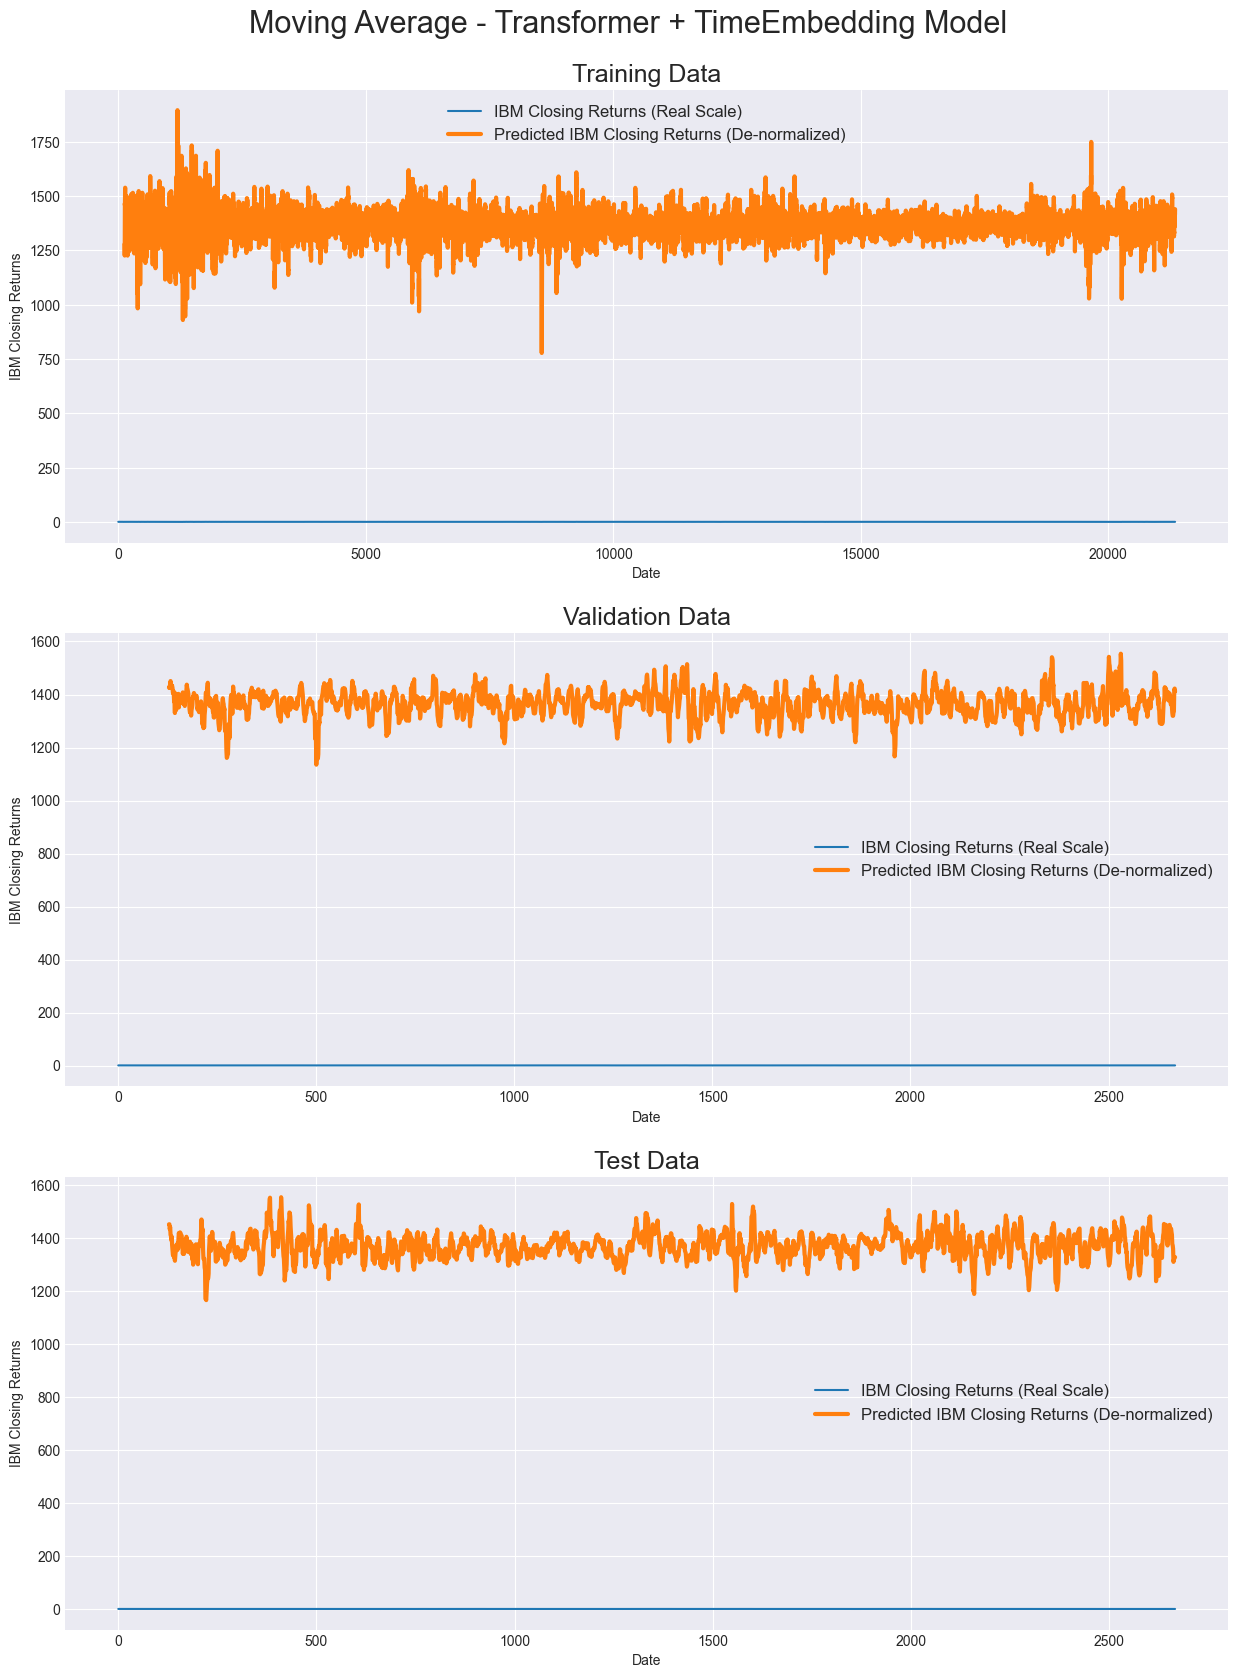

In [15]:
# Load original data again from file
original_df = pd.read_csv('XAUUSD240.csv')  # Replace with the actual path to your file

###############################################################################
'''Calculate predictions and metrics'''

# Calculate predictions for training, validation, and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

# Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''De-normalize the predictions'''

# Retrieve the min and max values for the prices from the original unmodified data
min_return = min(original_df[(original_df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(original_df[(original_df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].max(axis=0))

# Function to de-normalize predictions
def denormalize_predictions(pred, min_value, max_value):
    return (pred * (max_value - min_value)) + min_value

# De-normalize predictions for prices
train_pred_denorm = denormalize_predictions(train_pred, min_return, max_return)
val_pred_denorm = denormalize_predictions(val_pred, min_return, max_return)
test_pred_denorm = denormalize_predictions(test_pred, min_return, max_return)

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

# Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='IBM Closing Returns (Real Scale)')
ax11.plot(np.arange(seq_len, train_pred_denorm.shape[0]+seq_len), train_pred_denorm, linewidth=3, label='Predicted IBM Closing Returns (De-normalized)')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')
ax11.legend(loc="best", fontsize=12)

# Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='IBM Closing Returns (Real Scale)')
ax21.plot(np.arange(seq_len, val_pred_denorm.shape[0]+seq_len), val_pred_denorm, linewidth=3, label='Predicted IBM Closing Returns (De-normalized)')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')
ax21.legend(loc="best", fontsize=12)

# Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='IBM Closing Returns (Real Scale)')
ax31.plot(np.arange(seq_len, test_pred_denorm.shape[0]+seq_len), test_pred_denorm, linewidth=3, label='Predicted IBM Closing Returns (De-normalized)')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
ax31.legend(loc="best", fontsize=12)



## Moving Average - Model metrics

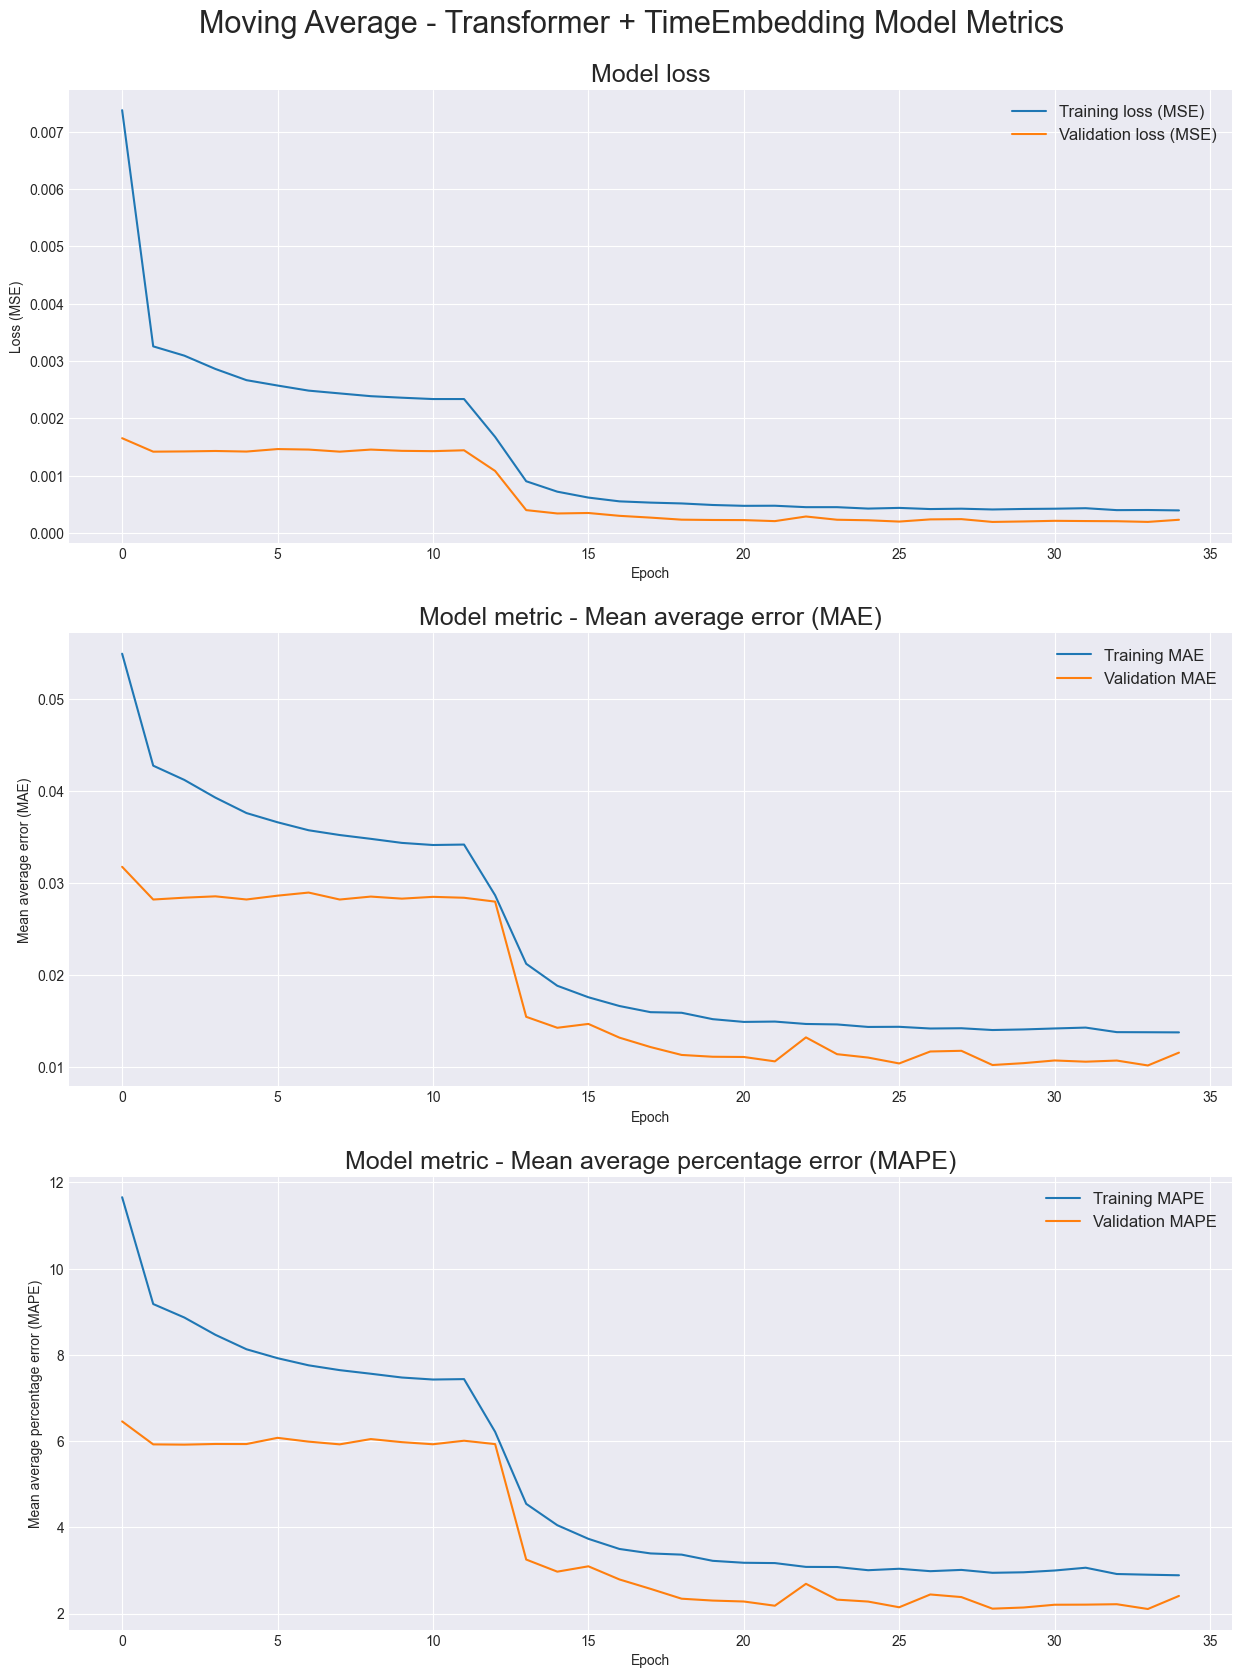

In [44]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

## Adding EMA and RSI 14 

Training data shape: (21346, 10)
Validation data shape: (2668, 10)
Test data shape: (2668, 10)


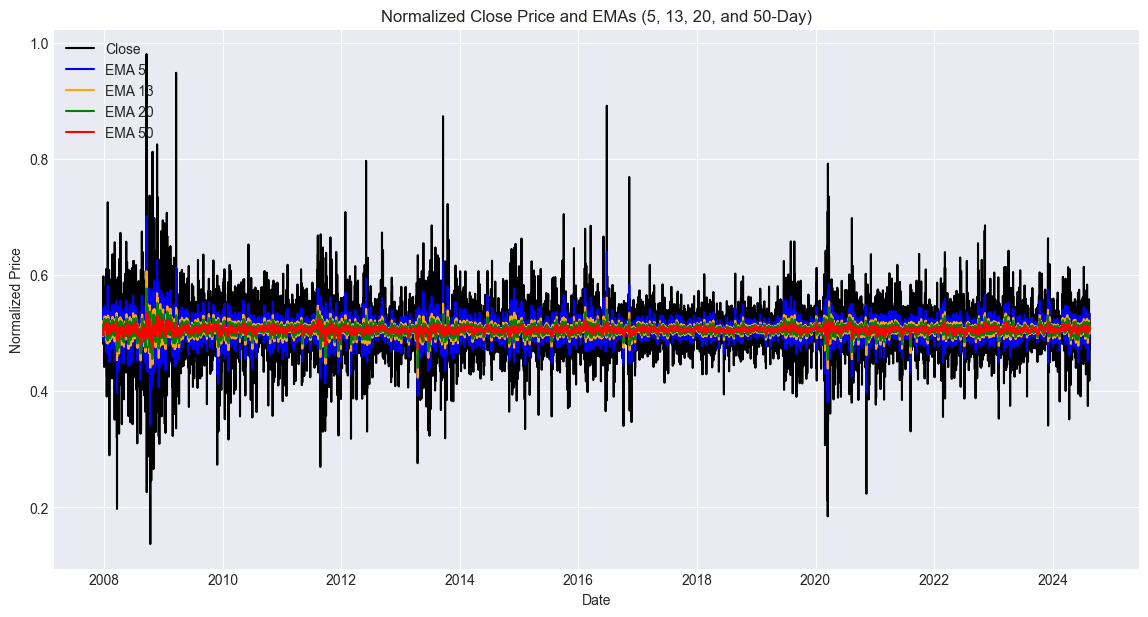

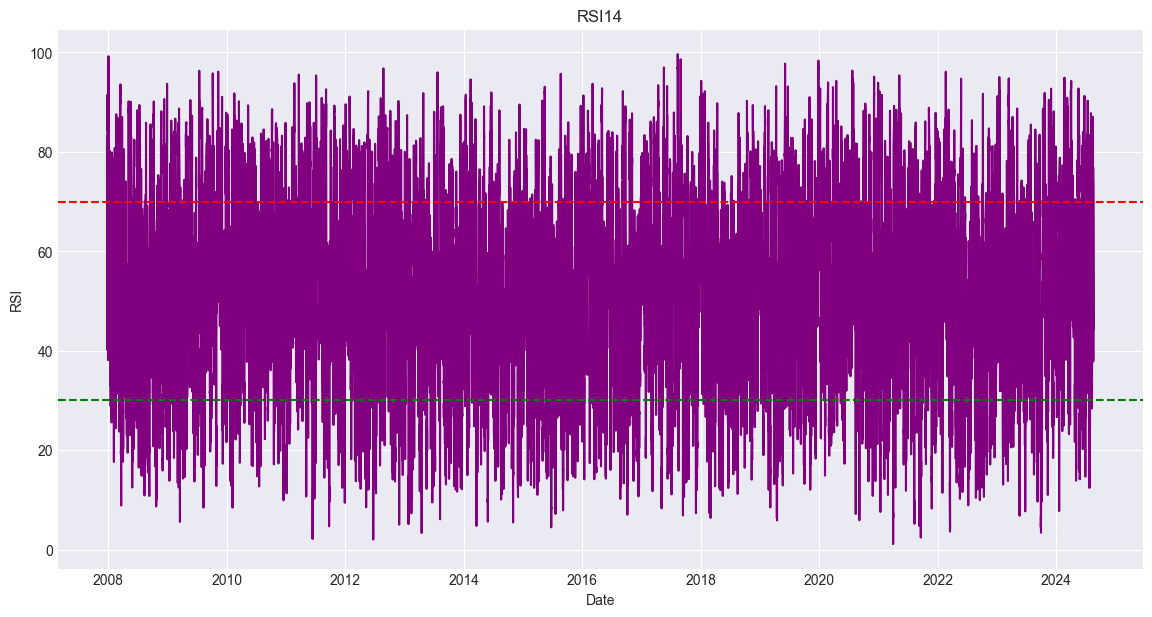

In [29]:
#Parameters
batch_size = 32
seq_len = 128
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

# Load your CSV data
XAUUSD_path = 'XAUUSD240.csv'
df = pd.read_csv(XAUUSD_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

# Convert 'Date' column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Calculate RSI14 on original data
def calculate_rsi(data, window):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI14'] = calculate_rsi(df['Close'], 14)

# Save the results with original data and RSI to a new CSV file
output_file = 'XAUUSD240_with_RSI.csv'
df.to_csv(output_file)

# Normalize data
df_norm = df.copy()

# Calculate percentage change
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    df_norm[col] = df_norm[col].pct_change()

df_norm.dropna(how='any', axis=0, inplace=True)

# Create indexes to split dataset
times = sorted(df_norm.index.values)
last_10pct = times[-int(0.1*len(times))]
last_20pct = times[-int(0.2*len(times))]

# Normalize price columns
min_return = df_norm[df_norm.index < last_20pct][['Open', 'High', 'Low', 'Close']].min().min()
max_return = df_norm[df_norm.index < last_20pct][['Open', 'High', 'Low', 'Close']].max().max()

for col in ['Open', 'High', 'Low', 'Close']:
    df_norm[col] = (df_norm[col] - min_return) / (max_return - min_return)

# Normalize volume column
min_volume = df_norm[df_norm.index < last_20pct]['Volume'].min()
max_volume = df_norm[df_norm.index < last_20pct]['Volume'].max()
df_norm['Volume'] = (df_norm['Volume'] - min_volume) / (max_volume - min_volume)

# Calculate EMAs on normalized data
for span in [5, 13, 20, 50]:
    df_norm[f'EMA_{span}'] = df_norm['Close'].ewm(span=span, adjust=False).mean()

# Add RSI to normalized data (not normalizing RSI itself)
df_norm['RSI14'] = df['RSI14']

# Create training, validation and test split
df_train = df_norm[df_norm.index < last_20pct]
df_val = df_norm[(df_norm.index >= last_20pct) & (df_norm.index < last_10pct)]
df_test = df_norm[df_norm.index >= last_10pct]

# Save normalized data to a new CSV file
normalized_output_file = 'XAUUSD240_normalized_with_EMAs_RSI.csv'
df_norm.to_csv(normalized_output_file)

# Convert pandas DataFrames into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values

print('Training data shape:', train_data.shape)
print('Validation data shape:', val_data.shape)
print('Test data shape:', test_data.shape)

# Plot EMAs on normalized data
plt.figure(figsize=(14, 7))
plt.plot(df_norm.index, df_norm['Close'], label='Close', color='black')
plt.plot(df_norm.index, df_norm['EMA_5'], label='EMA 5', color='blue')
plt.plot(df_norm.index, df_norm['EMA_13'], label='EMA 13', color='orange')
plt.plot(df_norm.index, df_norm['EMA_20'], label='EMA 20', color='green')
plt.plot(df_norm.index, df_norm['EMA_50'], label='EMA 50', color='red')
plt.title('Normalized Close Price and EMAs (5, 13, 20, and 50-Day)')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot RSI (unchanged)
plt.figure(figsize=(14, 7))
plt.plot(df_norm.index, df_norm['RSI14'], color='purple')
plt.title('RSI14')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.axhline(y=70, color='red', linestyle='--')
plt.axhline(y=30, color='green', linestyle='--')
plt.grid(True)
plt.show()

In [6]:
# Drop NaN values that may have been introduced by calculations
df.dropna(inplace=True)

# Prepare features and target
features = ['Open', 'High', 'Low', 'Close', 'Value']
features_ema_rsi = ['Open', 'High', 'Low', 'Close', 'Value', 'EMA', 'RSI']
target = 'Close'

In [6]:
 # Drop NaN values that may have been introduced by calculations
df.dropna(inplace=True)

# Prepare features and target
features = ['Open', 'High', 'Low', 'Close', 'Value']
features_ema_rsi = ['Open', 'High', 'Low', 'Close', 'Value', 'EMA', 'RSI']
target = 'Close'

In [12]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

In [27]:
# Load the normalized data
df_norm = pd.read_csv('XAUUSD240_normalized_with_EMAs_RSI.csv', index_col='Date', parse_dates=True)

# Features and parameters
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_5', 'EMA_13', 'EMA_20', 'EMA_50', 'RSI14']
batch_size = 32
seq_len = 128
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

# Prepare the data
data = df_norm[features].values
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size

train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
    X_train.append(train_data[i-seq_len:i])
    y_train.append(train_data[i, 3])  # Index 3 corresponds to 'Close'
X_train, y_train = np.array(X_train), np.array(y_train)

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[i, 3])
X_val, y_val = np.array(X_val), np.array(y_val)

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[i, 3])
X_test, y_test = np.array(X_test), np.array(y_test)

# Print shapes for verification
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

# # Create the model
# def create_model():
#     '''Initialize time and transformer layers'''
#     time_embedding = Time2Vector(seq_len)
#     attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
#     attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
#     attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

#     '''Construct model'''
#     in_seq = Input(shape=(seq_len, len(features)))  # Update input shape to handle all features
#     x = time_embedding(in_seq)
#     x = Concatenate(axis=-1)([in_seq, x])
#     x = attn_layer1((x, x, x))
#     x = attn_layer2((x, x, x))
#     x = attn_layer3((x, x, x))
#     x = GlobalAveragePooling1D(data_format='channels_first')(x)
#     x = Dropout(0.1)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(0.1)(x)
#     out = Dense(1, activation='linear')(x)

#     model = Model(inputs=in_seq, outputs=out)
#     model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
#     return model

# model = create_model()
# model.summary()

# # Set up callbacks and train the model
# callback = tf.keras.callbacks.ModelCheckpoint('Transformer_Financial_Model.keras', 
#                                               monitor='val_loss', 
#                                               save_best_only=True, 
#                                               verbose=1)

# history = model.fit(X_train, y_train, 
#                     batch_size=batch_size, 
#                     epochs=35, 
#                     callbacks=[callback],
#                     validation_data=(X_val, y_val))  

# Load the best model
model = tf.keras.models.load_model('Transformer_Financial_Model.keras',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

# Make predictions
predictions = model.predict(X_test)

# You can now compare predictions with y_test

(21217, 128, 10) (21217,)
(2540, 128, 10) (2540,)
(2541, 128, 10) (2541,)
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step


664/664 ━━━━━━━━━━━━━━━━━━━━ 64s 97ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step
Train Predictions: [[0.5054255]
 [0.5054255]
 [0.5054255]
 [0.5054255]
 [0.5054255]]
Validation Predictions: [[0.5054255]
 [0.5054255]
 [0.5054255]
 [0.5054255]
 [0.5054255]]
Test Predictions: [[0.5054255]
 [0.5054255]
 [0.5054255]
 [0.5054255]
 [0.5054255]]
Training MAPE: 96.06%
Validation MAPE: 96.65%
Test MAPE: 96.88%


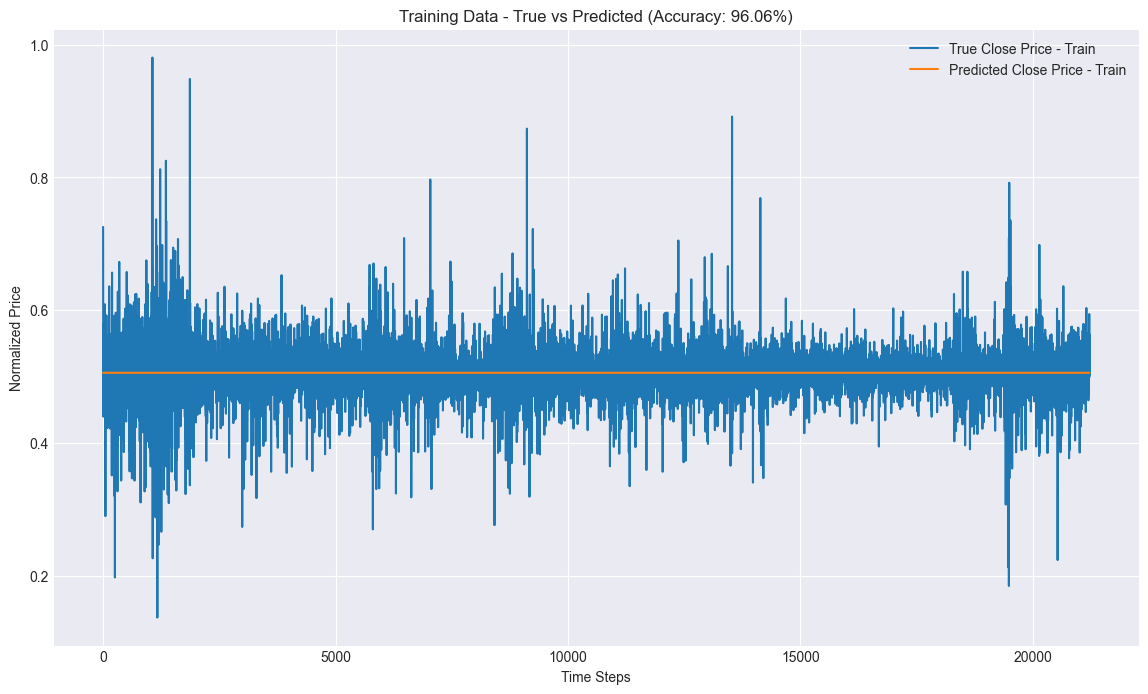

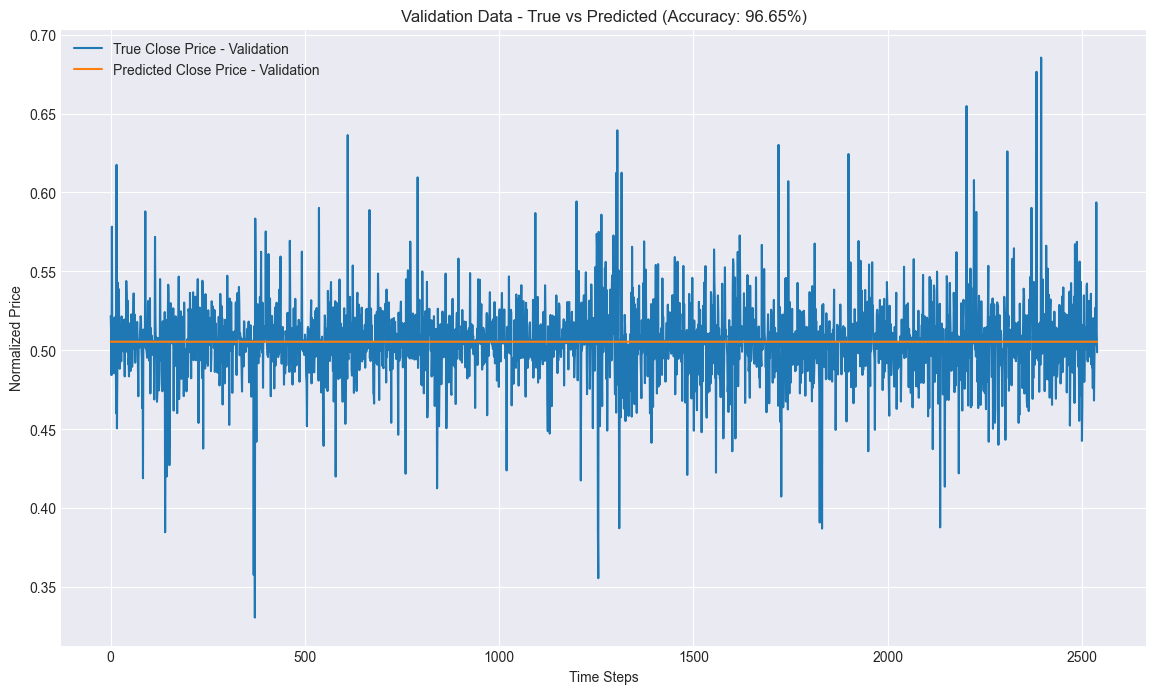

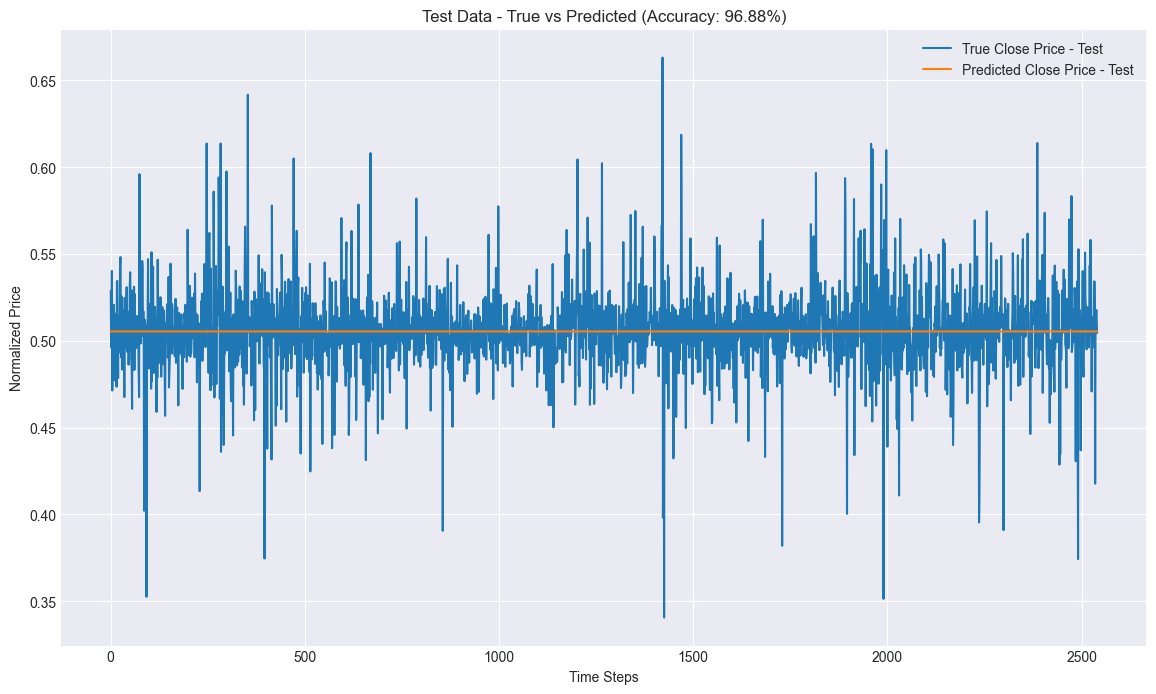

In [30]:
# Make predictions
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)

# Print predictions to verify (optional)
print(f'Train Predictions: {train_predictions[:5]}')
print(f'Validation Predictions: {val_predictions[:5]}')
print(f'Test Predictions: {test_predictions[:5]}')
# Calculate MAPE for accuracy
train_mape = np.mean(np.abs((y_train - train_predictions.flatten()) / y_train)) * 100
val_mape = np.mean(np.abs((y_val - val_predictions.flatten()) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - test_predictions.flatten()) / y_test)) * 100

# Print accuracy
print(f'Training MAPE: {100 - train_mape:.2f}%')
print(f'Validation MAPE: {100 - val_mape:.2f}%')
print(f'Test MAPE: {100 - test_mape:.2f}%')

# Plotting the results

# Plot training data results
plt.figure(figsize=(14, 8))
plt.plot(y_train, label='True Close Price - Train')
plt.plot(train_predictions, label='Predicted Close Price - Train')
plt.title(f'Training Data - True vs Predicted (Accuracy: {100 - train_mape:.2f}%)')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

# Plot validation data results
plt.figure(figsize=(14, 8))
plt.plot(y_val, label='True Close Price - Validation')
plt.plot(val_predictions, label='Predicted Close Price - Validation')
plt.title(f'Validation Data - True vs Predicted (Accuracy: {100 - val_mape:.2f}%)')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

# Plot test data results
plt.figure(figsize=(14, 8))
plt.plot(y_test, label='True Close Price - Test')
plt.plot(test_predictions, label='Predicted Close Price - Test')
plt.title(f'Test Data - True vs Predicted (Accuracy: {100 - test_mape:.2f}%)')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

In [42]:
# Load the non-normalized data
df_non_norm = pd.read_csv('XAUUSD240_with_EMAs_RSIs.csv', index_col='Date', parse_dates=True)

# Use the same features as in the training
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_5', 'EMA_13', 'EMA_20', 'EMA_50', 'RSI_14']

# Extract the data for prediction
data_non_norm = df_non_norm[features].values

# Set sequence length (same as used in the model training)
seq_len = 128

# Prepare the non-normalized data for testing
X_test_non_norm, y_test_non_norm = [], []
for i in range(seq_len, len(data_non_norm)):
    X_test_non_norm.append(data_non_norm[i-seq_len:i])
    y_test_non_norm.append(data_non_norm[i, 3])  # Index 3 corresponds to 'Close'
X_test_non_norm, y_test_non_norm = np.array(X_test_non_norm), np.array(y_test_non_norm)

print(X_test_non_norm.shape, y_test_non_norm.shape)

(26554, 128, 10) (26554,)


In [43]:
# Load the trained model
model = tf.keras.models.load_model('Transformer_Financial_Model.keras',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

# Make predictions on the non-normalized data
predictions_non_norm = model.predict(X_test_non_norm)

830/830 ━━━━━━━━━━━━━━━━━━━━ 82s 97ms/step


Test MAPE on Non-Normalized Data: 99.96%
Accuracy on Non-Normalized Data: 0.04%


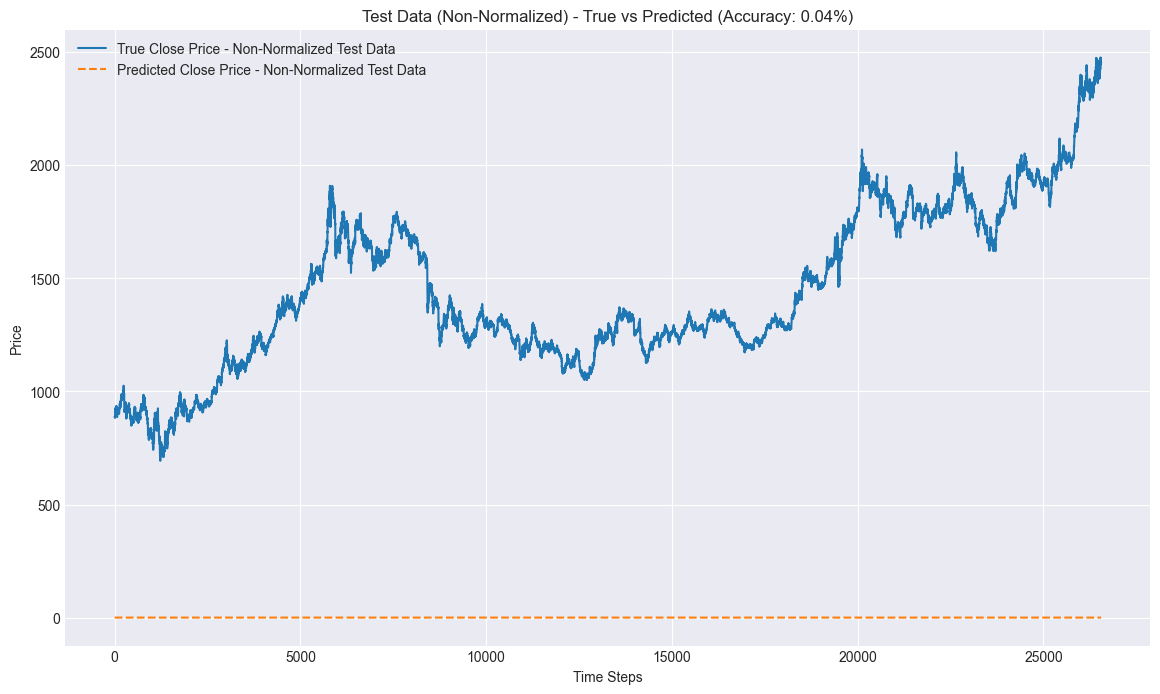

In [44]:
# Calculate MAPE for accuracy
test_mape_non_norm = np.mean(np.abs((y_test_non_norm - predictions_non_norm.flatten()) / y_test_non_norm)) * 100

# Print accuracy
print(f'Test MAPE on Non-Normalized Data: {test_mape_non_norm:.2f}%')
print(f'Accuracy on Non-Normalized Data: {100 - test_mape_non_norm:.2f}%')

# Plot test data results on non-normalized data
plt.figure(figsize=(14, 8))
plt.plot(y_test_non_norm, label='True Close Price - Non-Normalized Test Data')
plt.plot(predictions_non_norm, label='Predicted Close Price - Non-Normalized Test Data', linestyle='--')
plt.title(f'Test Data (Non-Normalized) - True vs Predicted (Accuracy: {100 - test_mape_non_norm:.2f}%)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()